In [ ]:
%pip install geopandas
%pip install rasterio
%pip install scipy

# Develop and Test GIS Functions

This notebook is for developing and testing the GIS functions implemented in `functions.py` using open-source libraries such as geopandas, rasterio, numpy, and scipy.

In [40]:
# Import Required Libraries
import os
import sys
import unittest
import geopandas as gpd
import pandas as pd
import rasterio
import numpy as np
import scipy


In [2]:
# Import functions from functions.py
cur_dir = os.path.abspath('.')
if cur_dir not in sys.path:
    sys.path.append(cur_dir)  # Ensure current directory is in path
sys.path

['/usr/local/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python313.zip',
 '/usr/local/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13',
 '/usr/local/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/lib-dynload',
 '',
 '/Users/landy/UoW/COMPX576/code/site-analyzer/experiments/.venv/lib/python3.13/site-packages',
 '/Users/landy/UoW/COMPX576/code/site-analyzer/experiments']

In [ ]:
def RPL_Select_analysis(input_shp, output_shp, conditions_expression):
    """
    Selects features from the input shapefile based on a given expression and saves them to an output shapefile.
    
    Parameters:
    - input_shp: Path to the input shapefile.
    - output_shp: Path to save the output shapefile.
    - conditions_expression: Expression to filter features. Example: "TA2025_V1_ == '001'".
    
    Returns:
    - None
    """
    gdf = gpd.read_file(input_shp)
    selected_gdf = gdf.query(conditions_expression)
    selected_gdf.to_file(output_shp)

def RPL_Clip_analysis(output, whole_area, boundary):
    """
    Clips a whole area shapefile to a specified boundary and saves the result.
    
    Parameters:
    - output: Path to save the clipped shapefile.
    - whole_area: Path to the whole area shapefile.
    - boundary: Path to the boundary shapefile.
    
    Returns:
    - None
    """
    whole_area_gdf = gpd.read_file(whole_area)
    boundary_gdf = gpd.read_file(boundary)
    
    clipped_gdf = gpd.clip(whole_area_gdf, boundary_gdf)
    clipped_gdf.to_file(output)

def RPL_Buffer_analysis(input, output, buffer_distance):
    """
    Creates a buffer around features in a shapefile and saves the result.
    Users can use `[axis.unit_name for axis in gdf.crs.axis_info]` to get the unit of a shapefile.
    
    Parameters:
    - input: Path to the input shapefile.
    - output: Path to save the buffered shapefile.
    - buffer_distance: Distance for the buffer (float, same unit as input shapefile).

    Returns:
    - None
    """
    gdf = gpd.read_file(input)
    buffered_gdf = gdf.buffer(distance=buffer_distance)
    buffered_gdf.to_file(output)

def RPL_Union_analysis(inputs, output):
    """
    Unions multiple shapefiles into a single shapefile, merging geometries and discarding attributes.
    
    Parameters:
    - inputs: List of paths to input shapefiles.
    - output: Path to save the unioned shapefile.
    
    Returns:
    - None
    """
    gds_list = [gpd.read_file(input).geometry for input in inputs]
    gs_all = gpd.GeoSeries(pd.concat(gds_list, ignore_index=True), crs=gds_list[0].crs)
    unioned =  gs_all.union_all()
    unioned.to_file(output)


<Axes: >

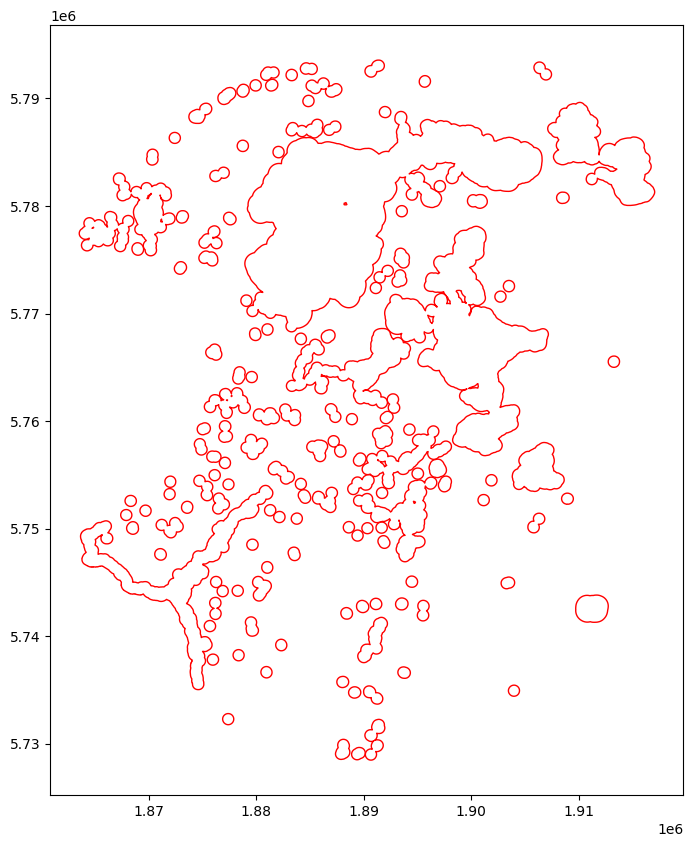

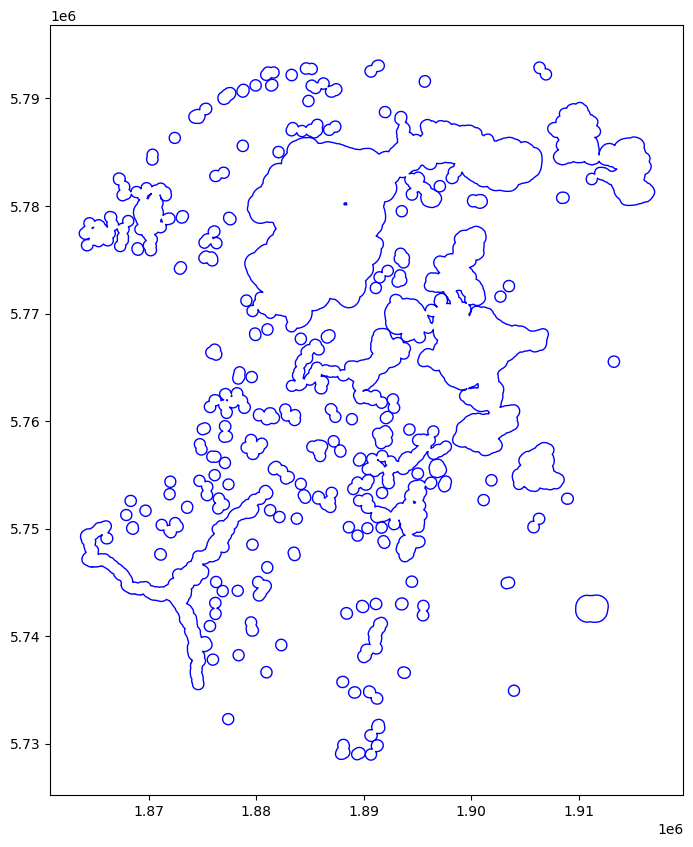

In [ ]:
# union buffered lake and residential areas in a specific district
buffered_lake_in_district_shp='/Users/landy/UoW/COMPX576/code/site-analyzer/output-data/buffered-lake-in-district.shp'
buffered_residential_in_district_shp='/Users/landy/UoW/COMPX576/code/site-analyzer/output-data/buffered-residential-in-district.shp'
unioned_in_district_shp='/Users/landy/UoW/COMPX576/code/site-analyzer/output-data/unioned-in-district.shp'
gdf1 = gpd.read_file(buffered_lake_in_district_shp)
gdf2 = gpd.read_file(buffered_residential_in_district_shp)
gs_all = gpd.GeoSeries(pd.concat([gdf1.geometry, gdf2.geometry], ignore_index=True), crs=gdf1.crs)

# gs_all.plot(figsize=(10, 10),facecolor='none', edgecolor='black')
unioned =  gpd.GeoSeries([gs_all.union_all()], crs=gs_all.crs)
unioned.plot(figsize=(10, 10), facecolor='none', edgecolor='red')
RPL_Union_analysis([buffered_lake_in_district_shp, buffered_residential_in_district_shp], unioned_in_district_shp)
gpd.read_file(unioned_in_district_shp).plot(figsize=(10, 10), facecolor='none', edgecolor='blue')

<Axes: >

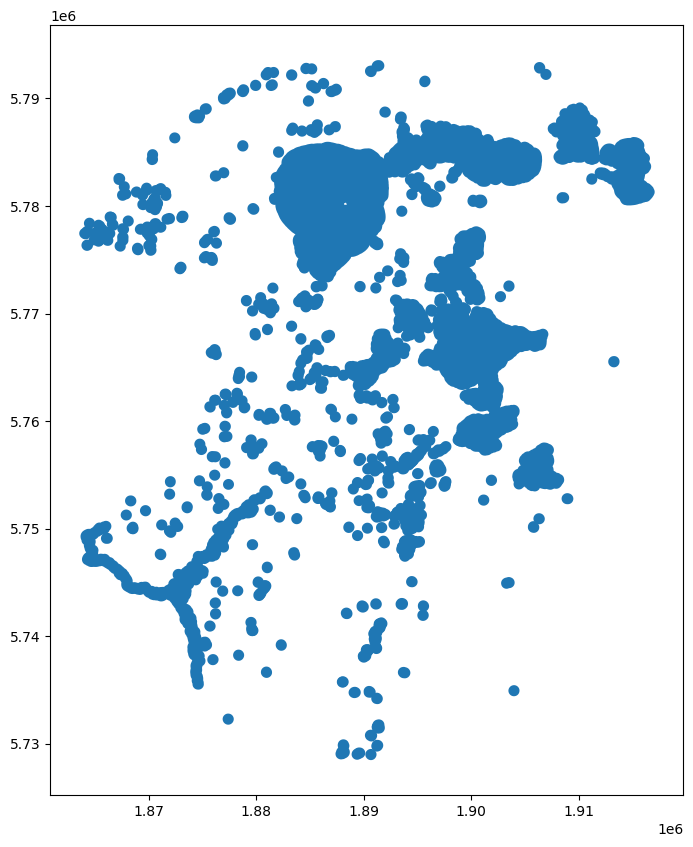

In [5]:
# Create buffer for lake areas in a specific district
lake_in_district_shp='/Users/landy/UoW/COMPX576/code/site-analyzer/output-data/lake-in-district.shp'
buffered_lake_in_district_shp='/Users/landy/UoW/COMPX576/code/site-analyzer/output-data/buffered-lake-in-district.shp'
RPL_Buffer_analysis(
    input=lake_in_district_shp,
    output=buffered_lake_in_district_shp,
    buffer_distance=500
)
gpd.read_file(buffered_lake_in_district_shp).plot(figsize=(10, 10))

<Axes: >

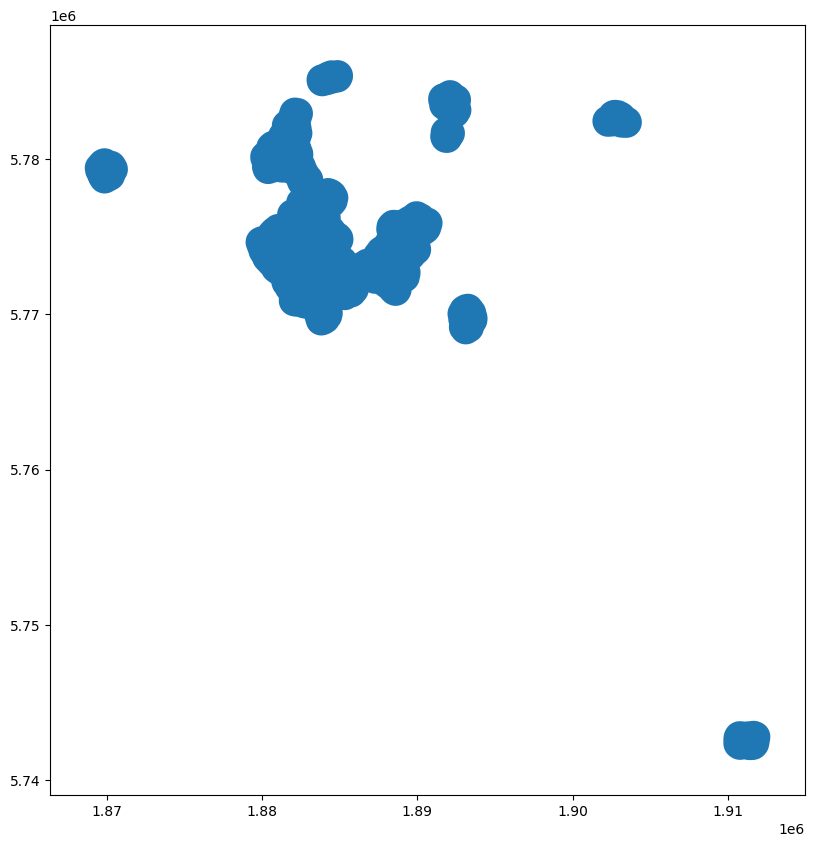

In [6]:
# Create buffer for residential areas in a specific district
residential_in_district_shp='/Users/landy/UoW/COMPX576/code/site-analyzer/output-data/residential-in-district.shp'
buffered_residential_in_district_shp='/Users/landy/UoW/COMPX576/code/site-analyzer/output-data/buffered-residential-in-district.shp'
RPL_Buffer_analysis(
    input=residential_in_district_shp,
    output=buffered_residential_in_district_shp,
    buffer_distance=1000
)
gpd.read_file(buffered_residential_in_district_shp).plot(figsize=(10, 10))

In [ ]:
# clip the residential polygons to the district boundary
all_residential_shp = '/Users/landy/UoW/COMPX576/code/site-analyzer/test-data/lds-nz-residential-area-polygons-topo-150k-SHP/nz-residential-area-polygons-topo-150k.shp'
district_shp='/Users/landy/UoW/COMPX576/code/site-analyzer/output-data/district.shp'
residential_in_district_shp='/Users/landy/UoW/COMPX576/code/site-analyzer/output-data/residential-in-district.shp'
RPL_Clip_analysis(
    output=residential_in_district_shp,
    whole_area=all_residential_shp,
    boundary=district_shp
)

<Axes: >

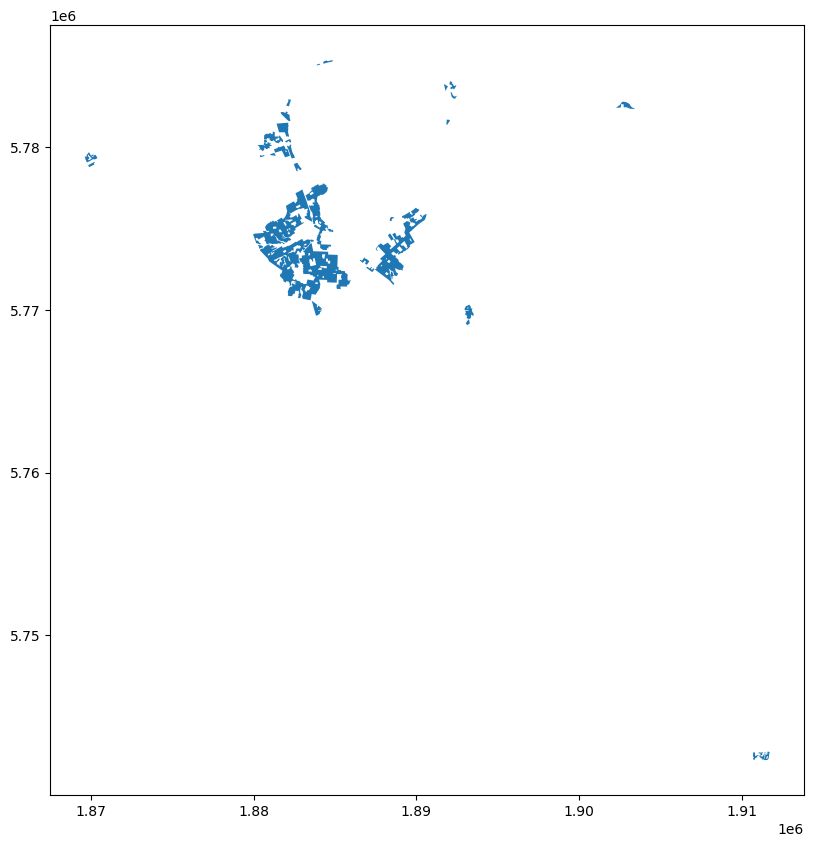

In [42]:
gpd.read_file(residential_in_district_shp).plot(figsize=(10, 10))

In [8]:
# clip the lake polygons to the district boundary
all_lake_shp = '/Users/landy/UoW/COMPX576/code/site-analyzer/test-data/lds-nz-lake-polygons-topo-150k-SHP/nz-lake-polygons-topo-150k.shp'
district_shp='/Users/landy/UoW/COMPX576/code/site-analyzer/output-data/district.shp'
lake_in_district_shp='/Users/landy/UoW/COMPX576/code/site-analyzer/output-data/lake-in-district.shp'
RPL_Clip_analysis(
    output=lake_in_district_shp,
    whole_area=all_lake_shp,
    boundary=district_shp
)

<Axes: >

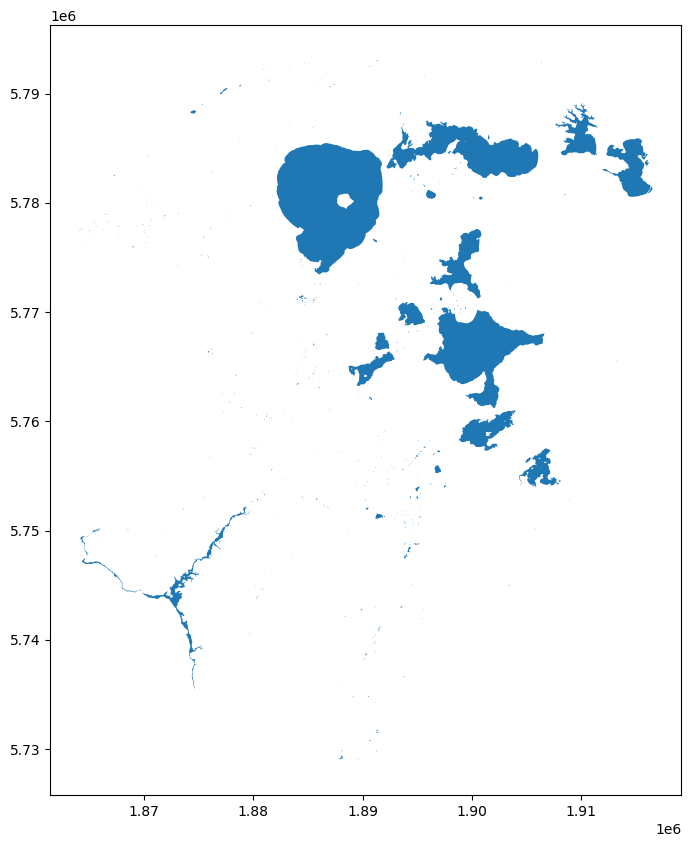

In [9]:
gpd.read_file(lake_in_district_shp).plot(figsize=(10, 10))

<Axes: >

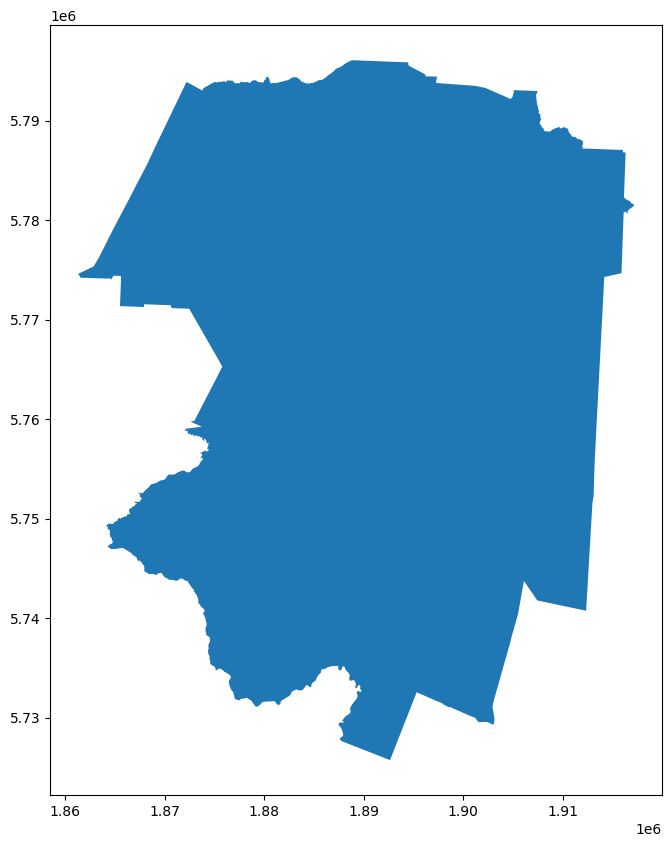

In [7]:
# extract a specific district (e.g., '002') from the territorial authority shapefile
input_shp='/Users/landy/UoW/COMPX576/code/site-analyzer/test-data/statsnz-territorial-authority-2025-clipped-SHP/territorial-authority-2025-clipped.shp'
output_shp='/Users/landy/UoW/COMPX576/code/site-analyzer/output-data/district.shp'
RPL_Select_analysis(
    input_shp=input_shp,
    output_shp=output_shp,
    conditions_expression=f"TA2025_V1_ == '024'"
)
gpd.read_file(output_shp).plot(figsize=(10, 10))